In [270]:
# Render our plots inline
%matplotlib inline

from requests import get
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from pandas.io.json import json_normalize

# Basic Settings
Here you need to specify where the API is running. The default port is 8080, so if you only change the machine, specify it's name in "server"

In [271]:
server = 'localhost'
server = 'hv-6066.idi.ntnu.no'

port = '8080'
url = 'http://' + server + ':' + port + '/'

# Case Representation

These methods show how to fetch an existing case representation from the APO 
Get the model contents: concept, attribute, attribute types

In [272]:
def get_concepts():
    raw = pd.DataFrame(requests.get(url + 'concepts/').json()) 
    concepts = pd.DataFrame.from_records(raw).values.tolist()
    return concepts

def get_globalsim(concept):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/amalgamationFunctions').json()) 
    global_sim = pd.DataFrame.from_records(raw).values.tolist()
    return global_sim

def get_attributes(concept):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/attributes').json()) 
    attributes = pd.DataFrame(raw).reset_index()
    attributes.columns = ['name', 'type']
    return attributes

def get_attribute_value_range(concept, attribute):
    raw = pd.DataFrame(requests.get(url + 'values?attribute%20name=' + attribute + '&concept%20name=' + concept).json()) 
    value_range = pd.Series.tolist(pd.DataFrame(raw).iloc[0])
    return value_range

# Case Base
Get the model contents: concept, casebase, attribute, attribute types

In [273]:
def get_casebases():
    raw = pd.DataFrame(requests.get(url + 'casebase/').json()) 
    casebases = pd.DataFrame.from_records(raw).values.tolist()
    return casebases

def get_instances(concept, casebase):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/instances').json()) 
    instances = raw.apply(pd.to_numeric, errors='coerce').fillna(raw)
    return instances

# Convenience Functions
- Create plots for case base content

In [274]:
def plot_numeric(data, attribute):
    ax = sns.distplot(data[attribute].astype(int), rug=True, hist=True, kde=False)
    ax.set(xlabel=attribute, ylabel='Count', title=attribute + ' (mean: '+data[attribute].astype(int).mean().__str__()+')')

def plot_symbolic(data, attribute):
    ax = sns.countplot(x=attribute, data=data, order = data[attribute].value_counts().index)
    ax.set(xlabel=attribute, ylabel='Dist', title=attribute)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Examples

The following cells will show how the fetch the content and configuration of the CBR via the Rest API.


In [275]:
get_concepts() # returns the list of concepts existing in the CBR system

[['Car']]

In [276]:
get_attributes(get_concepts()[0][0]) # returns a dataframe of attribute names and their type existing in the CBR system

,name,type
0,Body,SymbolDesc
1,CCM,IntegerDesc
2,Car Code,IntegerDesc
3,Color,SymbolDesc
4,Doors,IntegerDesc
5,Gas,SymbolDesc
6,Manufacturer,SymbolDesc
7,Miles,IntegerDesc
8,Model,SymbolDesc
9,Power,IntegerDesc


In [277]:
get_globalsim(get_concepts()[0][0]) # returns a list of names of existing global similarity functions

[['CarFunc']]

In [278]:
get_attribute_value_range('Car', 'Price')  # returns the value range for an attribute (min/max for numbers; entire list for symbols)

[[1.0, 100000.0]]

In [279]:
get_casebases() # returns the list of existing case bases

[['CaseBase0']]

In [280]:
get_instances('Car','CaseBase0').head() # returns the contents of the case base

,Body,CCM,Car Code,Color,Doors,Gas,Manufacturer,Miles,Model,Power,Price,Speed,Year,ZIP,caseID,similarity
0,sedan,2800,441,violet,4,gasoline,audi,29897,a6_2.8,193,49899,213,1995,8,441_audi,1
1,station_wagon,1600,108,turquoise,5,gasoline,audi,43858,a4_1.6,101,24699,183,1994,8,108_audi,1
2,station_wagon,3200,931,gray,5,gasoline,mercedes-benz,32855,e_320,224,60799,241,1996,4,931_mercedes-benz,1
3,sedan,3000,100,yellow,4,diesel,mercedes-benz,18146,e_300_diesel,176,58499,224,1996,3,100_mercedes-benz,1
4,sedan,3500,223,dark_green,4,gasoline,bmw,24711,m3,320,73299,241,1997,2,223_bmw,1


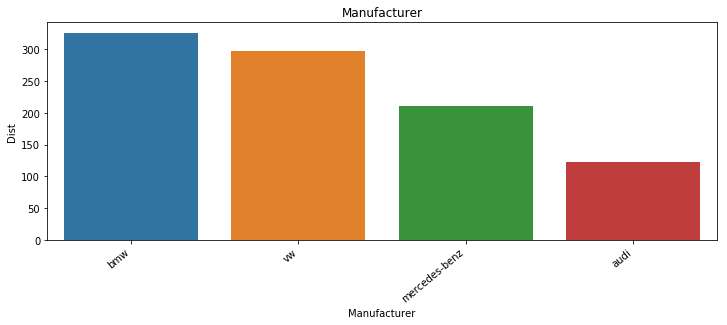

In [281]:
plt.rcParams["figure.figsize"] = (12, 4)
plot_symbolic(get_instances('Car','CaseBase0'), 'Manufacturer')

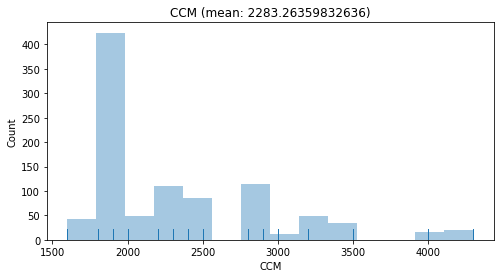

In [282]:
plt.rcParams["figure.figsize"] = (8, 4)
plot_numeric(get_instances('Car','CaseBase0'), 'CCM')

# Retrieval functions & visualizations
Example retrieval function that serve different purposes
- retrieve_k_sim_byID: This function uses the retrievalByID endpoint where a queryID is given (together with concept name, casebase name and k number of cases to be returned)

In [283]:
def retrieve_k_sim_byID(concept, casebase, queryID, k):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/retrievalByID?caseID=' + queryID + '&k=' + k ).json()) 
    results = raw.apply(pd.to_numeric, errors='coerce').fillna(raw).sort_values(by='similarCases', ascending=False)
    return results

def plot_retrieve_k_sim_byID(data):
    plt.xticks(rotation=35)
    ax = sns.barplot(x=data.index, y="similarCases", data=data)
    
def retrieve_k_sim_byID_content(concept, casebase, amalFct, queryID, k):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/retrievalByIDWithContent?amalgamation%20function='+amalFct+'&caseID=' + queryID + '&k=' + k ).json()) 
    results = raw.apply(pd.to_numeric, errors='coerce').fillna(raw).sort_values(by='similarity', ascending=False)
    returned_df = results.apply(pd.to_numeric, errors='coerce').fillna(results)
    return returned_df

def plot_retrieved_scatter(data, x_attr):
    plt.xticks(rotation=35)
    ax = sns.scatterplot(x=x_attr, y='similarity', data=data)



# Retrieval Examples

In [289]:
# Find most similar cases 
result_caseIDs = retrieve_k_sim_byID('Car', 'CaseBase0', '17_vw', '30')
result_caseIDs.head(10)

,similarCases
17_vw,1.000000
891_vw,0.658371
532_vw,0.658114
602_vw,0.632703
467_vw,0.632574
610_vw,0.599338
877_vw,0.599104
148_vw,0.593290
563_mercedes-benz,0.547150
173_vw,0.536384


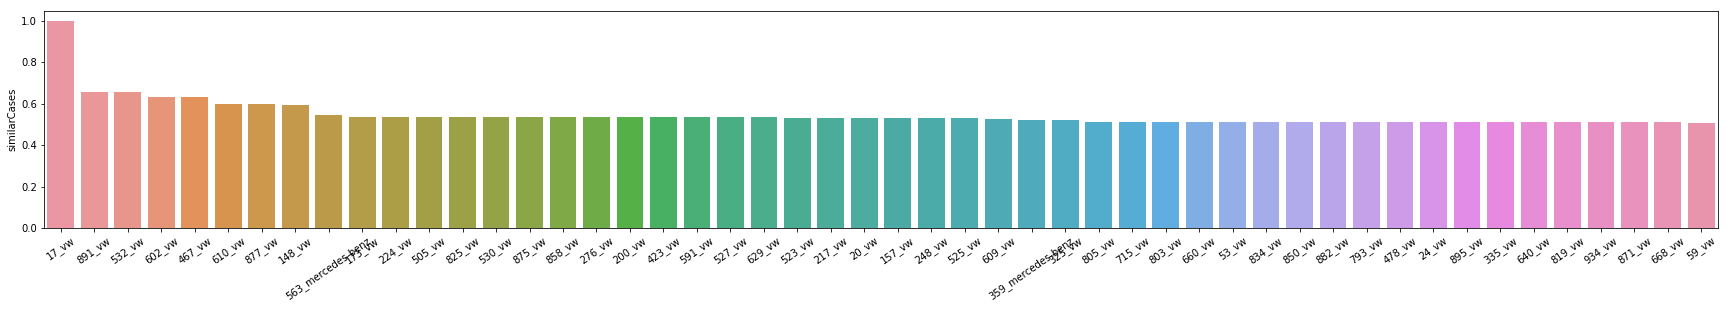

In [285]:
# Plot most similar cases - this requires result_caseIDs from the previous cell (called retrieve_k_sim_byID(..))
plt.rcParams["figure.figsize"] = (30, 4)
plot_retrieve_k_sim_byID(result_caseIDs)

In [286]:
# Find most similar cases and get the full case content for them
result_fullCases = retrieve_k_sim_byID_content('Car', 'CaseBase0', 'CarFunc', '17_vw', '30')
result_fullCases.head()

,Body,CCM,Car Code,Color,Doors,Gas,Manufacturer,Miles,Model,Power,Price,Speed,Year,ZIP,caseID,similarity
0,sedan,1900,17,dark_blue,4,diesel,vw,71433,passat,90,22099,183,1995,6,17_vw,1
1,sedan,1900,891,blue,4,diesel,vw,68993,passat,110,23599,183,1995,2,891_vw,0.658371
2,sedan,1900,532,dark_blue,4,diesel,vw,13701,passat,90,33199,183,1996,3,532_vw,0.658114
3,sedan,1900,602,blue,4,gasoline,vw,80748,passat,193,26499,183,1996,1,602_vw,0.632703
4,sedan,1900,467,dark_blue,4,gasoline,vw,91911,passat,100,16699,183,1995,8,467_vw,0.632574


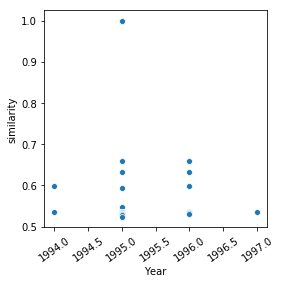

In [287]:
# Create a scatter plot showing the similarity vs. a specified attribute
plt.rcParams["figure.figsize"] = (4, 4)
plot_retrieved_scatter(result_fullCases, 'Year')

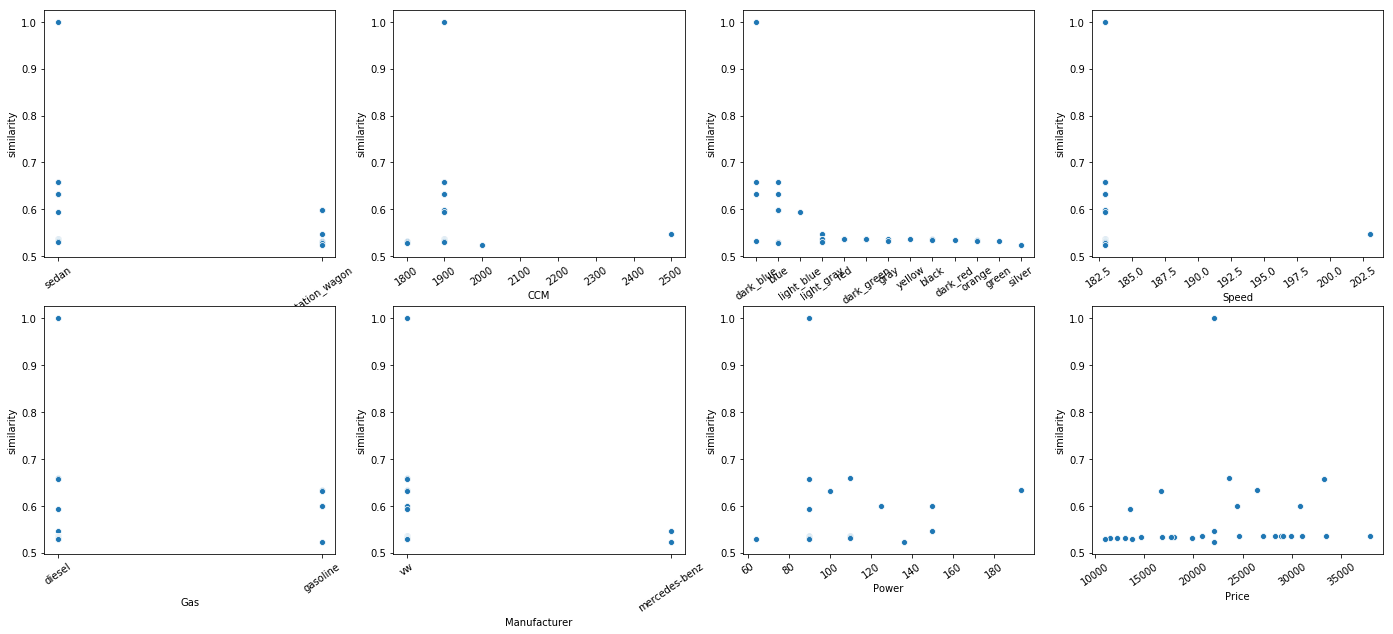

In [288]:
fig = plt.figure(figsize=(24,10))

plt.subplot(2, 4, 1)
plot_retrieved_scatter(result_fullCases, 'Body')

plt.subplot(2, 4, 2)
plot_retrieved_scatter(result_fullCases, 'CCM')

plt.subplot(2, 4, 3)
plot_retrieved_scatter(result_fullCases, 'Color')

plt.subplot(2, 4, 4)
plot_retrieved_scatter(result_fullCases, 'Speed')

plt.subplot(2, 4, 5)
plot_retrieved_scatter(result_fullCases, 'Gas')

plt.subplot(2, 4, 6)
plot_retrieved_scatter(result_fullCases, 'Manufacturer')

plt.subplot(2, 4, 7)
plot_retrieved_scatter(result_fullCases, 'Power')

plt.subplot(2, 4, 8)
plot_retrieved_scatter(result_fullCases, 'Price')

plt.show()